Show adding selective recurrent inhibition improves the performance of a Voja memory with when neuron noise is injected.

In [1]:
import string

import nengo
from nengo import processes
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.utils import BasicVecFeed

# Train basic Voja memory

In [6]:
seed = 8
D = 16
n_neurons = 100
n_items = 10
intercepts = np.ones(n_neurons) * 0.3

In [7]:
vocab = spa.Vocabulary(D, max_similarity=0.3)
vocab.populate(";".join([string.ascii_uppercase[i] for i in range(n_items)]))

In [8]:
vecs = vocab.vectors
simi = np.dot(vecs, vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.2643779801692851

In [9]:
t_present = 0.3
t_pause = 0.0
n_repeats = 5
t_each = t_present+t_pause

voja_learn_rate = 1e-5
pes_learn_rate = 1e-3

In [10]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    correct = nengo.Node(feed.get_answer)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts, neuron_type=nengo.LIF())

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))

    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=D + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

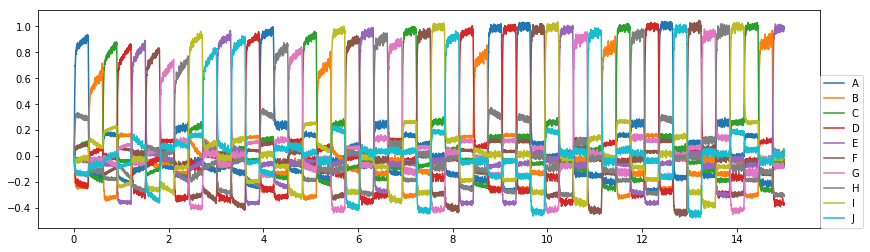

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [12]:
enc = sim.data[p_enc][-1]
dec = sim.data[p_dec][-1]

In [13]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

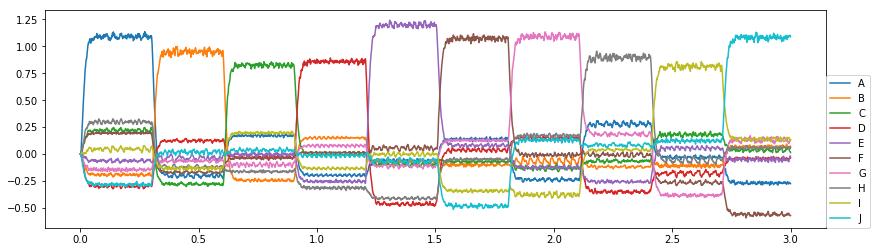

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Response to High Frequency noise

In [15]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [53]:
feed = BasicVecFeed(vecs, vecs, t_present, D, len(vecs), t_pause)
noise_proc = processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, 0.4), seed=1)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

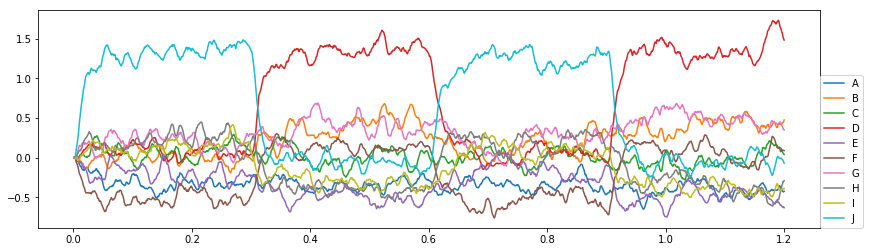

In [54]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Enhance with Analytical Rec BCM

For each input, get the rates of each neuron.

Outer-product and threshold.

In [24]:
base_inhib_mag = -2e-3

In [25]:
vecs = vocab.vectors

In [26]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

with nengo.Simulator(model) as sim:
    pass

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [27]:
_, activities = tuning_curves(ens, sim, inputs=vecs)

In [28]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for item in range(n_items):
    act_corr += np.outer(activities[item], activities[item])

np.fill_diagonal(act_corr, 0)

In [29]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 1] = 0
np.fill_diagonal(rec_w, 0)

In [30]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [37]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)
noise_proc = processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, 0.4), seed=1)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

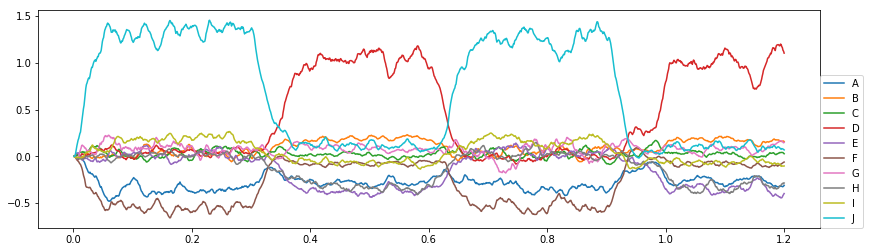

In [38]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [45]:
max_corr = np.max(act_corr)
print(max_corr)
min_corr = np.min(act_corr)
print(min_corr)

106994.543128
0.0


In [46]:
base_inhib = -2e-3

In [47]:
pos_corr = act_corr[act_corr > 0.]
min_pos_corr = np.min(pos_corr)

In [48]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib
rec_w[act_corr > 0.] = np.interp(pos_corr, (min_pos_corr, max_corr), (base_inhib, 1e-2)) 
np.fill_diagonal(rec_w, 0)

In [49]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = (1 - act_corr[act_corr > 0.] / max_corr) * -4e-5
np.fill_diagonal(rec_w, 0)

In [50]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [51]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

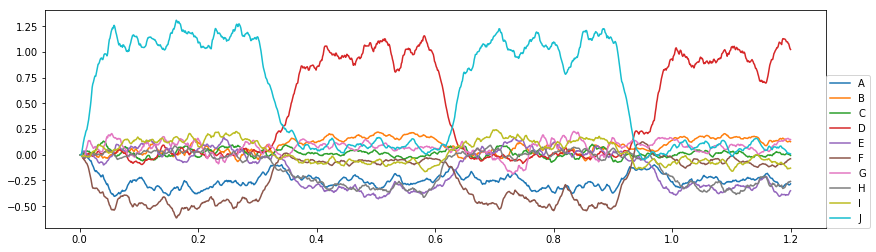

In [52]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

Very slight improvement when responding to low magnitude neural noise, in terms of giving a more confident response. But hardly any difference between basic analytic setting of the weights and subtlely grading the weights on correlation, which is a good thing for biological plausibility.